# Environment Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from kerastuner import HyperModel, RandomSearch, BayesianOptimization, Hyperband

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('Running TensorFlow  ', tf.__version__)
print('Running KerasTuner  ', kt.__version__)
print("GPUs Available:  ", len(tf.config.experimental.list_physical_devices('GPU')))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'

Running TensorFlow2.2.0
Running KerasTuner1.0.1
GPUs Available:1


# Understanding the Data

Import dataset and preview:

In [2]:
dataset = pd.read_csv('Concrete_Data.csv')
print(dataset.head())
print("Shape of data set:", dataset.shape)

cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
0   540.0    0.0     0.0  162.0        2.5      1040.0     676.0   28   
1   540.0    0.0     0.0  162.0        2.5      1055.0     676.0   28   
2   332.5  142.5     0.0  228.0        0.0       932.0     594.0  270   
3   332.5  142.5     0.0  228.0        0.0       932.0     594.0  365   
4   198.6  132.4     0.0  192.0        0.0       978.4     825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30
Shape of data set:(1030, 9)


Check normality in dataset for further anaylsis

In [29]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(dataset)
normal = normal.apply(test_normality)
print('Is dataset normal?', not normal.any())

Is dataset normal?False


Plot distributions of dataset to understand the nature of the data

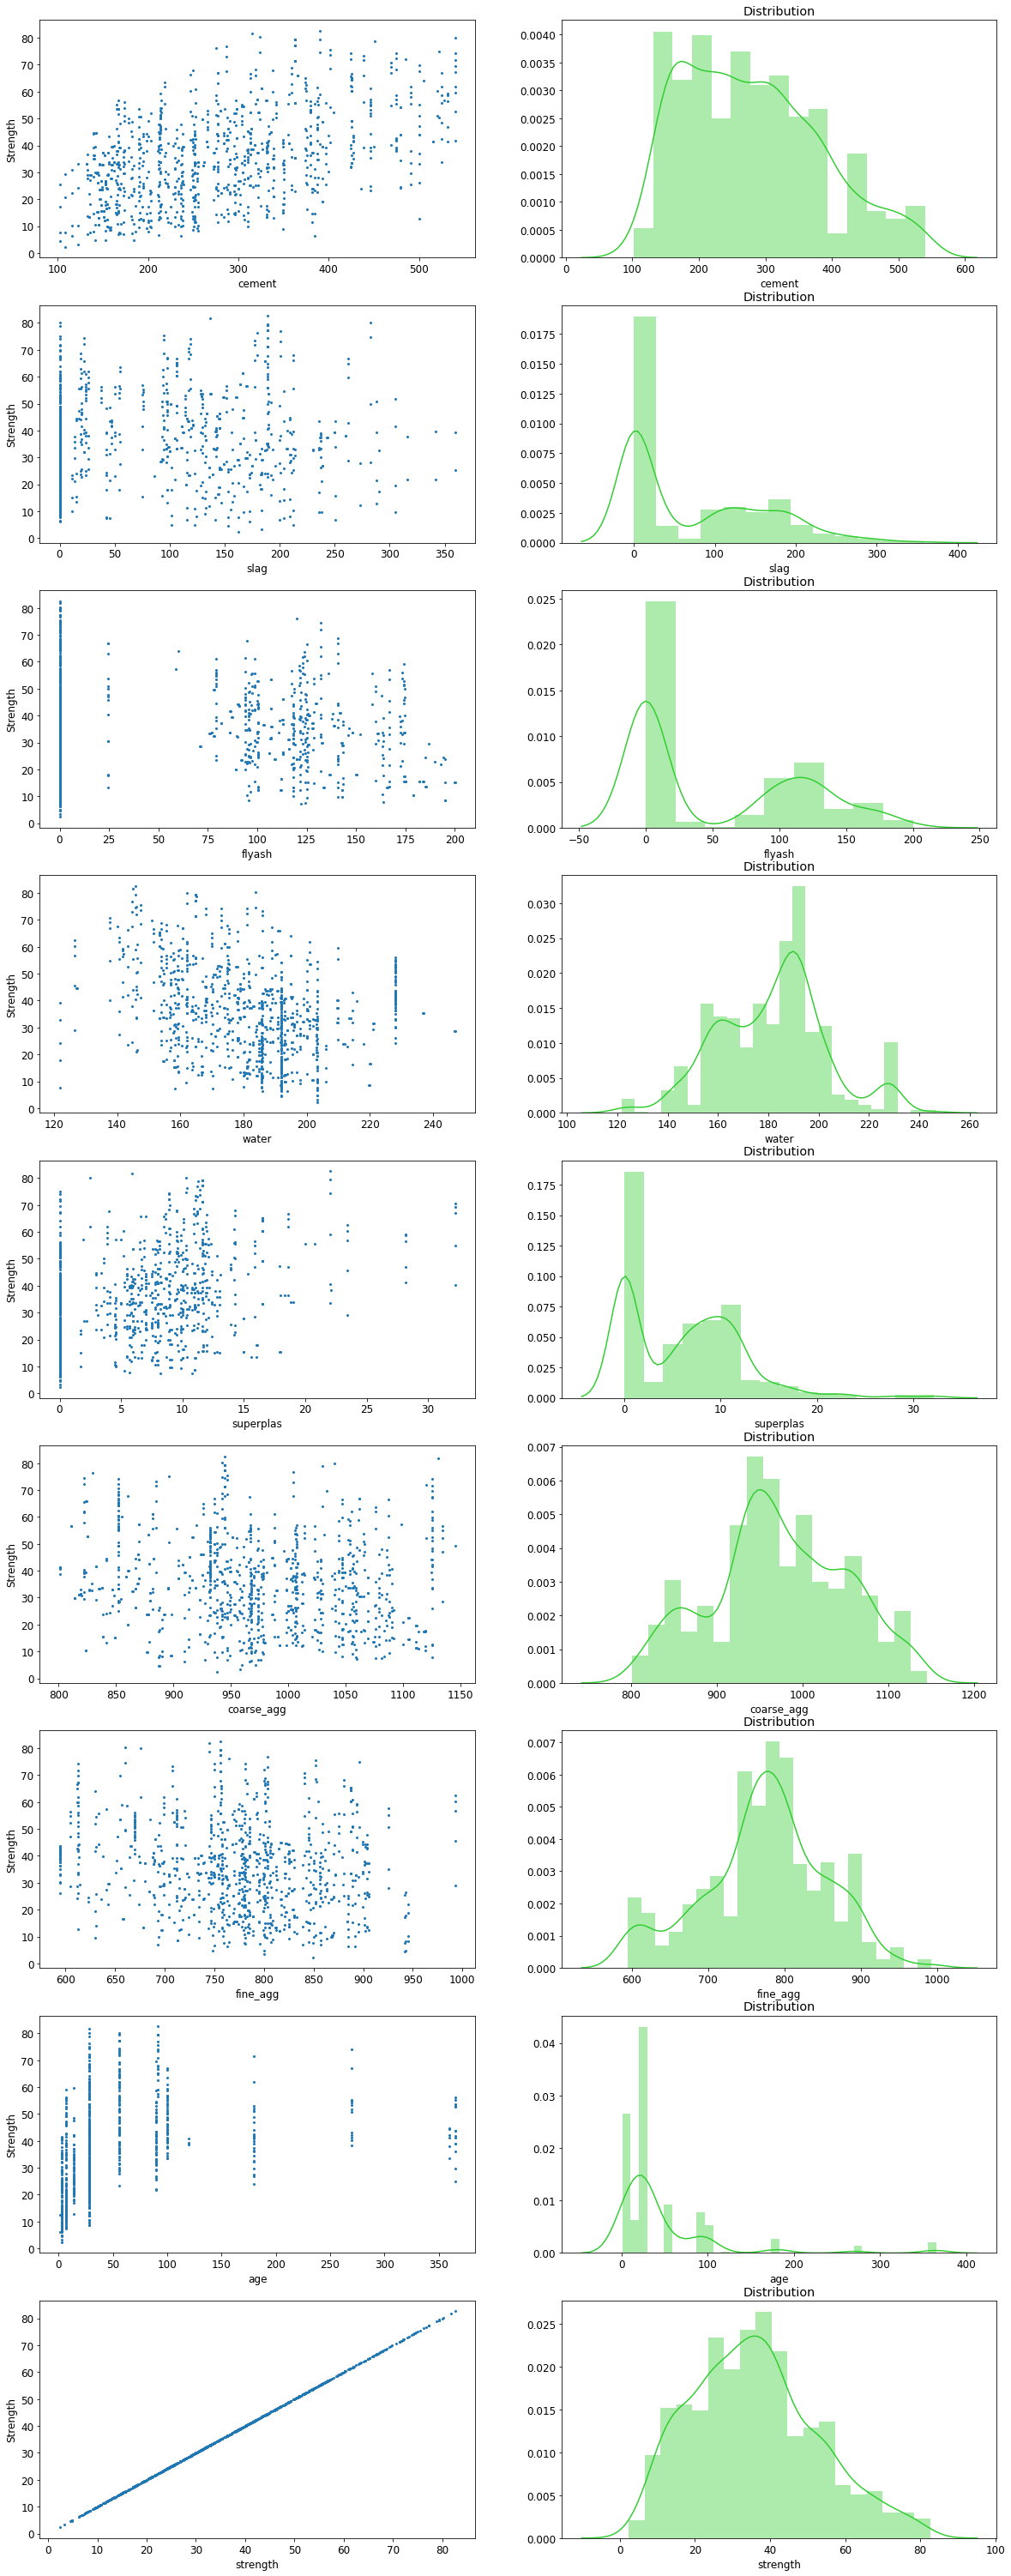

In [4]:
keys = [f for f in dataset.columns if dataset.dtypes[f] != 'object']

fig, ax = plt.subplots(len(keys),2,figsize=(20,len(keys)*6))

for n in range(len(keys)):
    feat = keys[n]
    ax[n,0].scatter(dataset[feat].values, dataset.strength.values, s=4)
    ax[n,0].set_ylabel("Strength")
    ax[n,0].set_xlabel(feat);
    sns.distplot(dataset[feat].dropna(), kde=True, ax=ax[n,1], color="limegreen")
    ax[n,1].set_title("Distribution")

In [5]:
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 6
import random as rn
rn.seed(seed)
np.random.seed(seed)

tf.random.set_seed(seed)

Split dataset for training and testing

In [6]:
# from sklearn.model_selection import train_test_split
# train_x, test_x, train_y, test_y = train_test_split(dataset.drop('strength', axis=1), dataset['strength'], test_size=0.2, random_state=42)
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

train_dataset = dataset.sample(frac=0.8,random_state=69)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.head(), train_dataset.shape)
print(test_dataset.head(), test_dataset.shape)

cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
42    237.5  237.5     0.0  228.0        0.0       932.0     594.0  365   
184   222.4    0.0    96.7  189.3        4.5       967.1     870.3    3   
131   379.5  151.2     0.0  153.9       15.9      1134.3     605.0   28   
550   393.0    0.0     0.0  192.0        0.0       940.6     785.6    7   
808   252.0    0.0     0.0  186.0        0.0      1111.0     784.0    7   

     strength  
42      39.00  
184     11.58  
131     52.20  
550     27.74  
808     11.47(824, 9)
    cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
9    475.0    0.0     0.0  228.0        0.0       932.0     594.0   28   
19   475.0    0.0     0.0  228.0        0.0       932.0     594.0  180   
24   380.0    0.0     0.0  228.0        0.0       932.0     670.0  365   
37   332.5  142.5     0.0  228.0        0.0       932.0     594.0   90   
39   237.5  237.5     0.0  228.0        0.0       932.0     594.0  180   

    str

In [7]:
train_stats = train_dataset.describe()
train_stats.pop('strength')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cement,824.0,281.377306,104.495567,102.0,194.4,269.40,351.250,540.0
slag,824.0,73.903277,86.092338,0.0,0.0,22.00,142.500,359.4
flyash,824.0,53.997937,63.164905,0.0,0.0,0.00,118.300,195.0
water,824.0,181.990413,21.217147,121.8,164.9,185.70,192.000,247.0
superplas,824.0,6.206311,6.001590,0.0,0.0,6.35,10.325,32.2
coarse_agg,824.0,972.764320,78.171931,801.0,932.0,968.00,1030.000,1145.0
fine_agg,824.0,773.141262,80.462484,594.0,724.3,780.10,824.250,992.6
age,824.0,44.993932,62.216931,1.0,7.0,28.00,56.000,365.0


In [8]:
train_labels = train_dataset.pop('strength')
test_labels = test_dataset.pop('strength')

print(train_labels.head(), train_labels.shape)

42     39.00
184    11.58
131    52.20
550    27.74
808    11.47
Name: strength, dtype: float64(824,)


## Standardise Data

Data is standardised to improve model performance

cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
42  -0.419896  1.900247 -0.854872  2.168510  -1.034111   -0.521470 -2.226395   
184 -0.564400 -0.858419  0.676041  0.344513  -0.284310   -0.072460  1.207504   
131  0.939013  0.897835 -0.854872 -1.323949   1.615187    2.066415 -2.089685   
550  1.068205 -0.858419 -0.854872  0.471769  -1.034111   -0.411456  0.154839   
808 -0.281134 -0.858419 -0.854872  0.188979  -1.034111    1.768354  0.134954   

          age  
42   5.143392  
184 -0.674960  
131 -0.273140  
550 -0.610669  
808 -0.610669


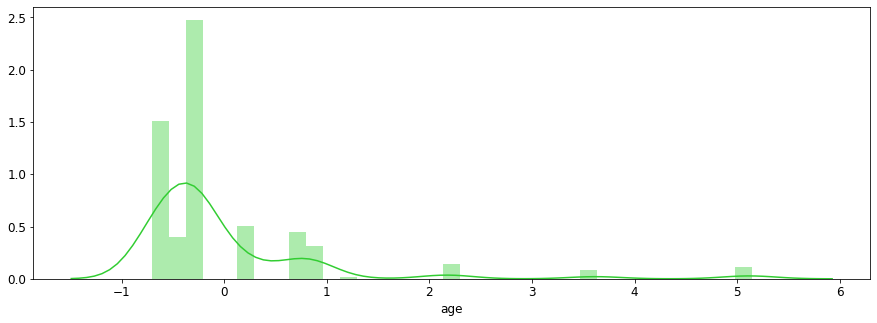

In [9]:
def norm(x):
  # return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data.head())

sns.distplot(normed_train_data['age'], kde=True, color="limegreen")


# Train Model

Create sequential artificial neural network 

In [10]:
def train_network(structure, activation, optimizer, epochs):
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units = structure[1], input_dim = structure[0], activation = activation, kernel_regularizer=regularizers.l2(0.001))) 
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[2], activation = activation, kernel_regularizer=regularizers.l2(0.001)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[3], activation = activation, kernel_regularizer=regularizers.l2(0.001)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[-1], activation = None))
    
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])

    print(model.summary(), '\n')
    print('training... ')
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
    training_stats = model.fit(normed_train_data, train_labels, batch_size = 32, epochs = epochs, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

    return training_stats, model

In [11]:
for hidden1 in range (128, 513, 128):
    print('Evaluating model with %i hidden neurons... ' %hidden1, '\n')
    training_stats, model = train_network(structure = [8, hidden1, hidden1, hidden1, 1], activation = 'relu', optimizer = 'RMSprop', epochs = 1000)
    hist = pd.DataFrame(training_stats.history)
    hist['epoch'] = training_stats.epoch
    print(hist.tail(), '\n')

Evaluating model with 128 hidden neurons...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 128)               1152
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129
Total params: 34,305
Trainable params: 34,305
Non-trainable params: 0
_________________________________________________________________
None

training...
          loss       mae        mse   val_loss   val_mae    val_mse  epoch
133  14.556518  2.911244  14.171112  30.698479  3.896174  30.311871    133
134  16.794910  3.136078  16.408033  32.714245  3.995815  32.32

In [12]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPa".format(mae))

7/7 - 0s - loss: 54.9343 - mae: 5.6793 - mse: 53.9646
Testing set Mean Abs Error:  5.68 MPa


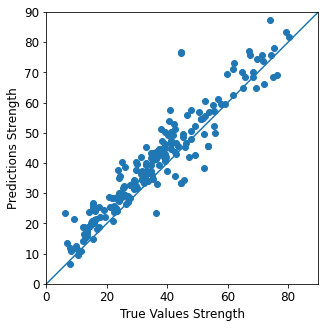

In [13]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


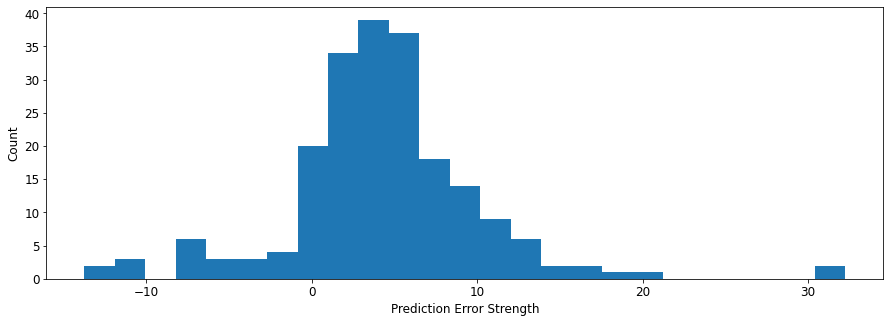

In [14]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error Strength")
_ = plt.ylabel("Count")

# Automating Hyperparameter tuning with Keras Tuner

Hyperparameter tuning can be automated with 

In [19]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape    
        
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(
            keras.layers.Dense(
                units=hp.Int('units', 64, 128, 16, default=64),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
                
            )
        )
        model.add(
            layers.Dropout(0.5)
        ) 
        model.add(
            keras.layers.Dense(
                units=hp.Int('units', 64, 128, 16, default=64),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )
        model.add(
            layers.Dropout(0.5)
        ) 
        model.add(layers.Dense(1))
        model.compile(
            optimizer='rmsprop',loss='mse',metrics=['mse']
        )
        return model

## Bayesian Optimisation

In [23]:
input_shape = (normed_train_data.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2,
            directory='kerastuner/baysianOptimisation')

tuner_bo.search(normed_train_data, train_labels, batch_size = 32, epochs = 128, validation_split = 0.2, verbose = 0)
best_model = tuner_bo.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(normed_test_data, test_labels)

INFO:tensorflow:Oracle triggered exit
1/7 [===>..........................] - ETA: 0s - loss: 59.9026 - mse: 59.9027/7 [==============================] - 0s 1ms/step - loss: 47.2641 - mse: 47.2641


## Random Search

In [24]:
input_shape = (normed_train_data.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2,
            directory='kerastuner/randomSearch')

tuner_rs.search(normed_train_data, train_labels, batch_size = 32, epochs = 128, validation_split = 0.2, verbose = 0)
best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(normed_test_data, test_labels)

INFO:tensorflow:Oracle triggered exit
1/7 [===>..........................] - ETA: 0s - loss: 65.9871 - mse: 65.9877/7 [==============================] - 0s 2ms/step - loss: 46.1274 - mse: 46.1274


## Hyperband

In [27]:
input_shape = (normed_train_data.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner_hb = Hyperband(
            hypermodel,
            objective='mse',
            max_epochs=8,
            seed=42,
            executions_per_trial=2,
            directory='kerastuner/hyperBand')

tuner_hb.search(normed_train_data, train_labels, batch_size = 32, epochs = 128, validation_split = 0.2, verbose = 0)
best_model = tuner_hb.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(normed_test_data, test_labels)

INFO:tensorflow:Oracle triggered exit
1/7 [===>..........................] - ETA: 0s - loss: 267.7764 - mse: 267.7767/7 [==============================] - 0s 2ms/step - loss: 190.3879 - mse: 190.3879
